In [ ]:
## Utils
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow as imgshow

In [ ]:
## Load Models and protos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## CONSTANTS
C_PATH= os.getcwd()
DIR_MODELS = os.path.join(C_PATH, './drive/MyDrive/TFG_data/models/')
DIR_PROTOS = os.path.join(C_PATH, './drive/MyDrive/TFG_data/protos/')
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
AGELIST = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
O_INDEX = np.array([i for i in range(0, 101)])
FACEPROTO = os.path.join(DIR_PROTOS, "opencv_face_detector.pbtxt")
FACEMODEL = os.path.join(DIR_MODELS, "opencv_face_detector_uint8.pb")
AGEPROTO_A = DIR_PROTOS + "age_deploy.prototxt"
AGEMODEL_A = DIR_MODELS + "age_net.caffemodel"
AGEPROTO_I = DIR_PROTOS + "age.prototxt"
AGEMODEL_I = DIR_MODELS + "dex_chalearn_iccv2015.caffemodel"

In [ ]:
## Upload image
from google.colab import files
images = files.upload()

Saving jon.jpg to jon (1).jpg


In [ ]:
# Load the Caffe model
faceNet = cv2.dnn.readNet(FACEMODEL,FACEPROTO)
ageNet_A = cv2.dnn.readNet(AGEMODEL_A,AGEPROTO_A)
ageNet_I = cv2.dnn.readNet(AGEMODEL_I,AGEPROTO_I)

In [ ]:
## Functions
def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn=frame.copy()
    frameHeight=frameOpencvDnn.shape[0]
    frameWidth=frameOpencvDnn.shape[1]
    blob=cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections=net.forward()
    faceBoxes=[]
    for i in range(detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>conf_threshold:
            x1=int(detections[0,0,i,3]*frameWidth)
            y1=int(detections[0,0,i,4]*frameHeight)
            x2=int(detections[0,0,i,5]*frameWidth)
            y2=int(detections[0,0,i,6]*frameHeight)
            faceBoxes.append([x1,y1,x2,y2])
            cv2.rectangle(frameOpencvDnn, (x1,y1), (x2,y2), (0,255,0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn,faceBoxes
# --------------------------------------------------------------

In [ ]:
# age adience function
def age_adience(face):
    blob=cv2.dnn.blobFromImage(face, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)
    ageNet_A.setInput(blob)
    agePreds=ageNet_A.forward()
    age=AGELIST[agePreds[0].argmax()]
    return age
# age imdb function
def age_imdb(face):
    face = cv2.resize(face, (224, 224))
    blob=cv2.dnn.blobFromImage(face)
    ageNet_I.setInput(blob)
    age_dist = ageNet_I.forward()[0]
    age = round(np.sum(age_dist * O_INDEX))
    return age

In [ ]:
# Select Model
mode = "imdb" #@param ["imdb", "adience", "both"] { run: "auto" }
print('You selected', mode)

You selected both


Age_adience: 38-43 years
Age_imdb: 31 years


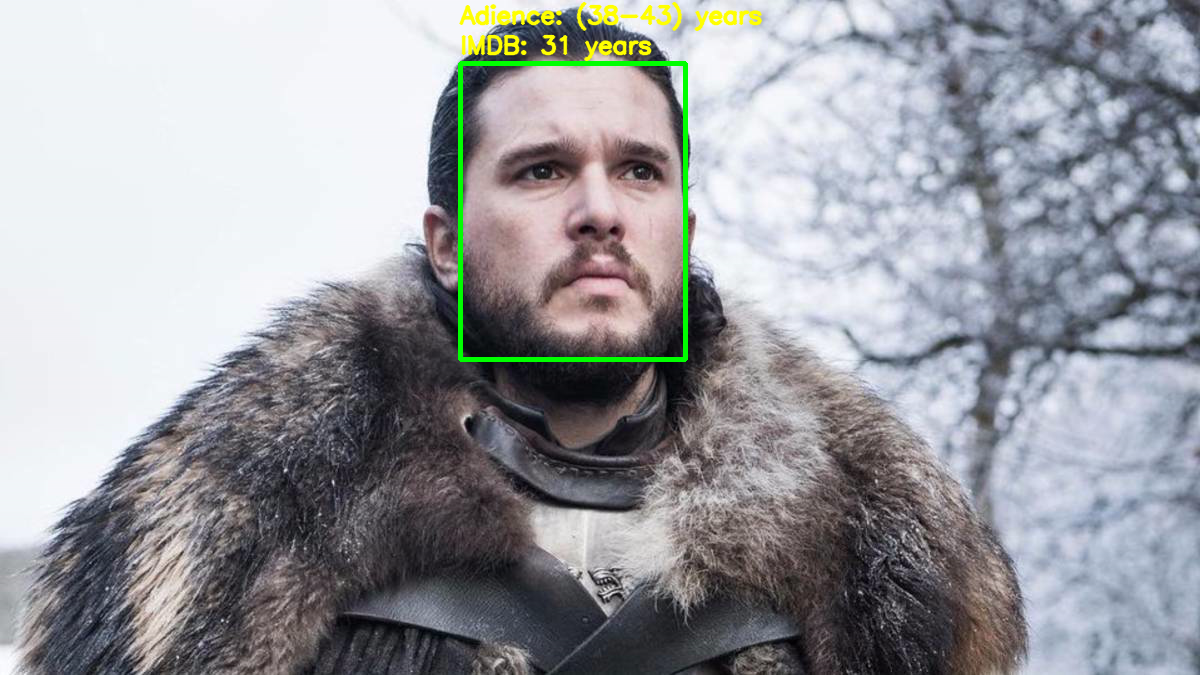

In [ ]:
# Load the image
for name, data in images.items():
  video=cv2.VideoCapture(name)
  padding=20
  while cv2.waitKey(1)<0:
      hasFrame,frame=video.read()
      if not hasFrame:
          cv2.waitKey()
          break

      resultImg,faceBoxes=highlightFace(faceNet,frame)
      if not faceBoxes:
          print("No face detected")
          break

      for faceBox in faceBoxes:
          face=frame[max(0,faceBox[1]-padding):
                    min(faceBox[3]+padding,frame.shape[0]-1),max(0,faceBox[0]-padding)
                    :min(faceBox[2]+padding, frame.shape[1]-1)]
          if mode == 'imdb':
              age = age_imdb(face)
              print(f'Age: {age} years')
              cv2.putText(resultImg, f'{age} years', (faceBox[0], faceBox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2, cv2.LINE_AA)
  
          elif mode == 'adience':
              age = age_adience(face)
              print(f'Age: {age[1:-1]} years')
              cv2.putText(resultImg, f'{age} years', (faceBox[0], faceBox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2, cv2.LINE_AA)

          elif mode == 'both':
              age_adience_r = age_adience(face)
              age_imdb_r = age_imdb(face)
              print(f'Age_adience: {age_adience_r[1:-1]} years')
              print(f'Age_imdb: {age_imdb_r} years')
              cv2.putText(resultImg, f'Adience: {age_adience_r} years', (faceBox[0], faceBox[1]-40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2, cv2.LINE_AA)
              cv2.putText(resultImg, f'IMDB: {age_imdb_r} years', (faceBox[0], faceBox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2, cv2.LINE_AA)
      
      imgshow(resultImg)